In [457]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

In [458]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")

In [459]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [460]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [461]:
head(meta_new)

subject_id,sample_id,time,cc,age_d,age_d_s,bf_count,bf_count_s,bf_ratio
207,sa_10000,post,no,98.00,0.0320946,6.00,0.43948544,1
388,sa_10038,post,yes,98.00,0.0320946,0.00,-1.65710371,0
381,sa_10118,post,yes,108.00,0.5275689,6.59,0.64565004,1
283,sa_10211,post,yes,107.03,0.4795079,5.00,0.09005391,1
216,sa_10230,post,no,100.00,0.1311895,7.00,0.78891696,1
277,sa_10247,pre,yes,79.00,-0.9093066,6.10,0.47442859,1


In [462]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [463]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance.

In [483]:
# how many NA? --> 4 CC and 1 no CC
# sd_to_df(pseq.rel) %>% filter(is.na(bf_count_s))
# complete cases for meta data and otus:
meta.rel <- sd_to_df(pseq.rel) %>% na.omit()
otus.rel <- otu_to_df(pseq.rel, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.rel$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.rel)
anova(betadisper(dist, meta.rel$cc))
anova(betadisper(dist, meta.rel$time))
anova(betadisper(dist, meta.rel$groups))
pm <- adonis(otus.rel ~ time * cc + age_d_s + bf_count_s, method = "bray", data = meta)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,0.01068243,0.01068243,0.2699701,0.6039763
Residuals,184,7.28068431,0.03956894,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,0.0461526,0.04615260,1.165474,0.2817462
Residuals,184,7.2863698,0.03959984,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,3,0.1296018,0.04320061,1.106874,0.3476845
Residuals,182,7.1033467,0.03902938,NA,NA


In [484]:
pm$aov.tab

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
time,1,0.12804849,0.12804849,1.0703913,0.005701042,0.328
cc,1,0.09689544,0.09689544,0.8099747,0.004314029,0.491
age_d_s,1,0.26246073,0.26246073,2.1939789,0.011685414,0.072
bf_count_s,1,0.30644673,0.30644673,2.5616696,0.013643781,0.038
time:cc,1,0.13369918,0.13369918,1.1176270,0.005952625,0.346
Residuals,180,21.53299239,0.11962774,NA,0.958703110,NA
Total,185,22.46054296,NA,NA,1.000000000,NA


Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


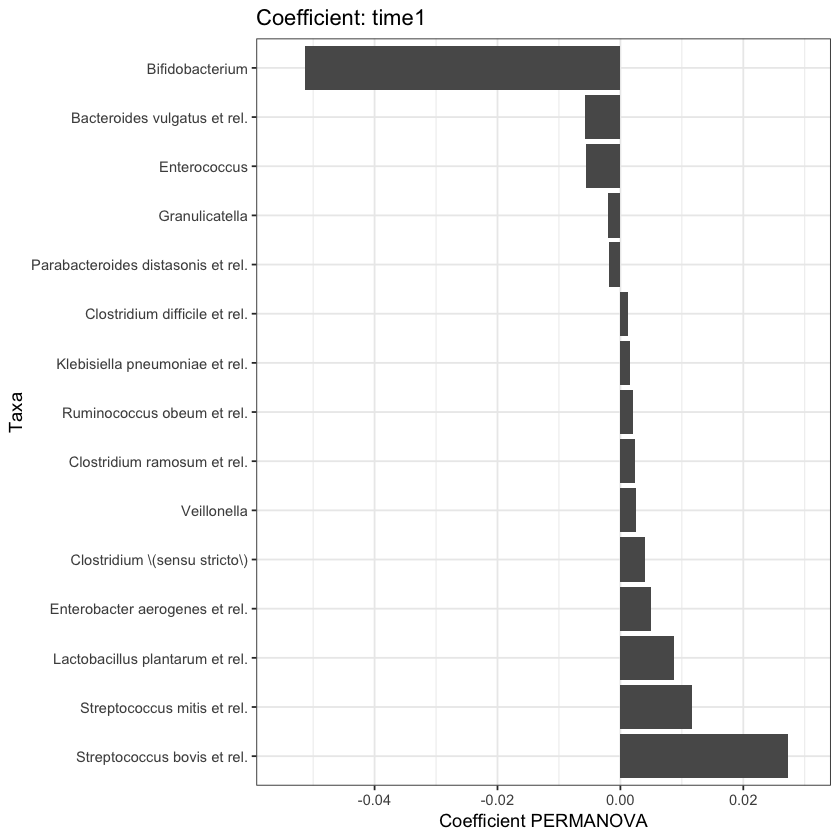

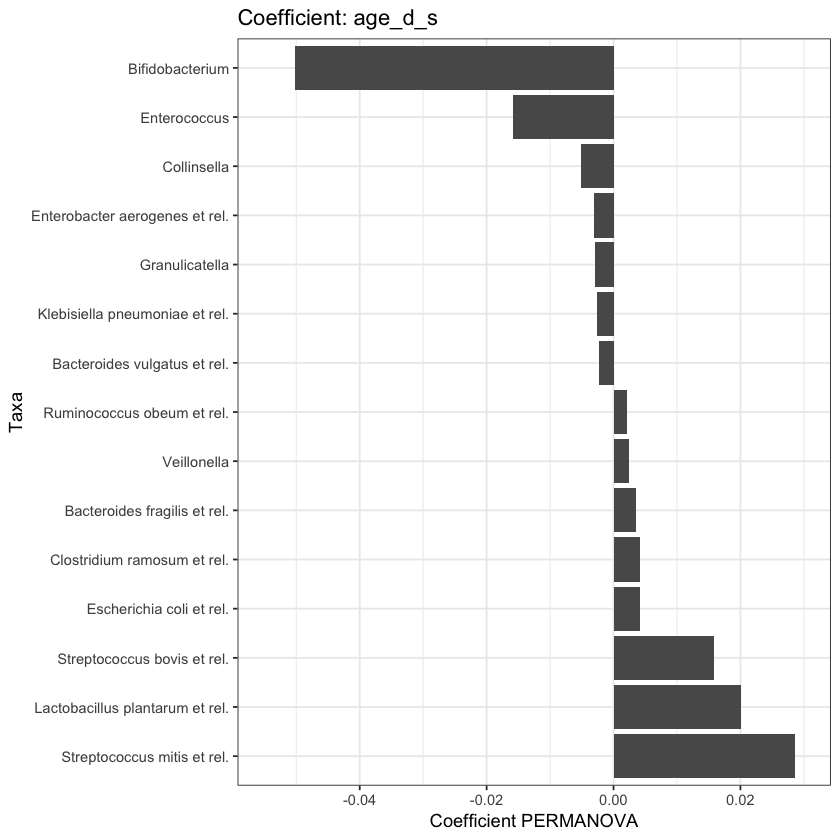

[[1]]

[[2]]

[[3]]

[[4]]


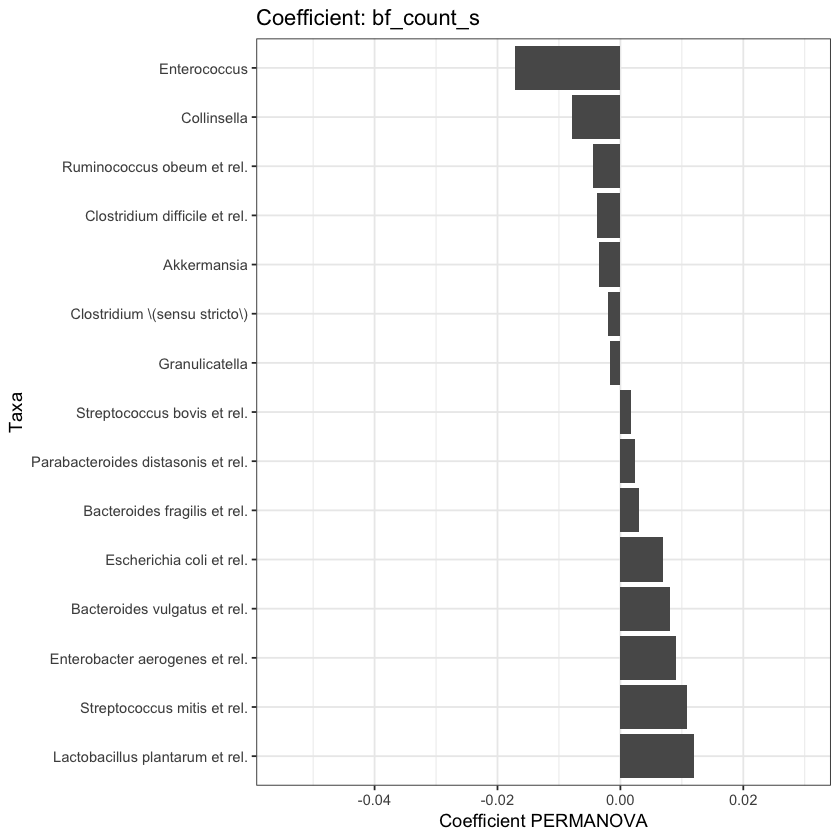

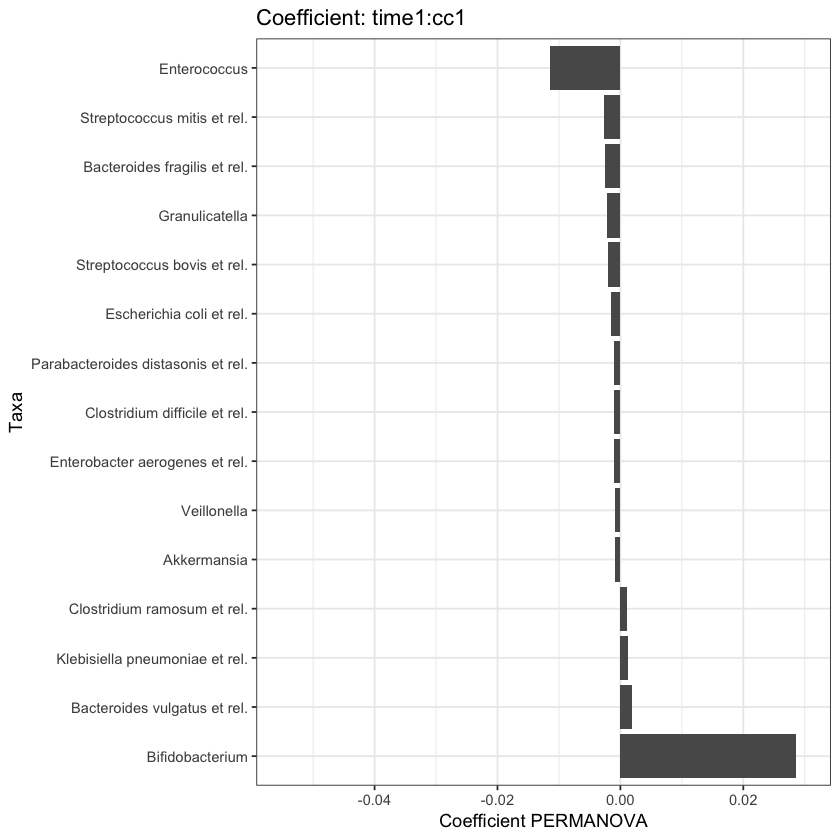

In [486]:
coef_v <- c("time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.055, 0.03) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_rel_ab.png")))
    p
})
pmps

In [487]:
# clr/euclidean
meta.clr <- sd_to_df(pseq.clr) %>% na.omit()
otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
    column_to_rownames("species") %>%
    select(meta.clr$sample_id) %>%
    t() 

# Homogeneity assumption 
dist <- vegdist(otus.clr, method = "euclidean")
anova(betadisper(dist, meta.clr$cc))
anova(betadisper(dist, meta.clr$time))
anova(betadisper(dist, meta.clr$groups))
pm <- adonis(otus.clr ~ time * cc + age_d_s + bf_count_s, method = "euclidean", data = meta.clr)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,12.70196,12.701957,2.183616,0.141196
Residuals,184,1070.31617,5.816936,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,11.29962,11.299622,1.925837,0.1668928
Residuals,184,1079.59814,5.867381,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,3,26.14298,8.714327,1.465732,0.2254244
Residuals,182,1082.05840,5.945376,NA,NA


In [488]:
pm$aov.tab

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
time,1,54.24036,54.24036,1.3570874,0.007132591,0.173
cc,1,46.46194,46.46194,1.1624724,0.006109732,0.303
age_d_s,1,65.49927,65.49927,1.6387839,0.008613134,0.082
bf_count_s,1,208.93909,208.93909,5.2276314,0.027475429,0.001
time:cc,1,35.16045,35.16045,0.8797104,0.004623589,0.550
Residuals,180,7194.27847,39.96821,NA,0.946045523,NA
Total,185,7604.57958,NA,NA,1.000000000,NA


Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
“Removed 1 rows containing missing values (position_stack).”Saving 7 x 7 in image
Saving 7 x 7 in image
Warning message:
“Removed 1 rows containing missing values (position_stack).”

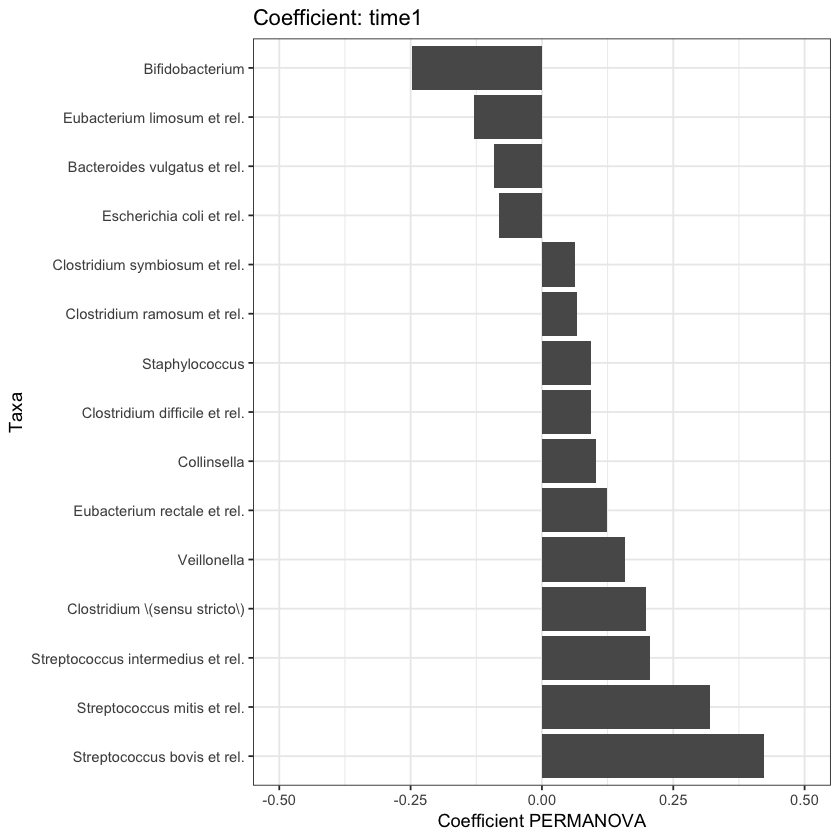

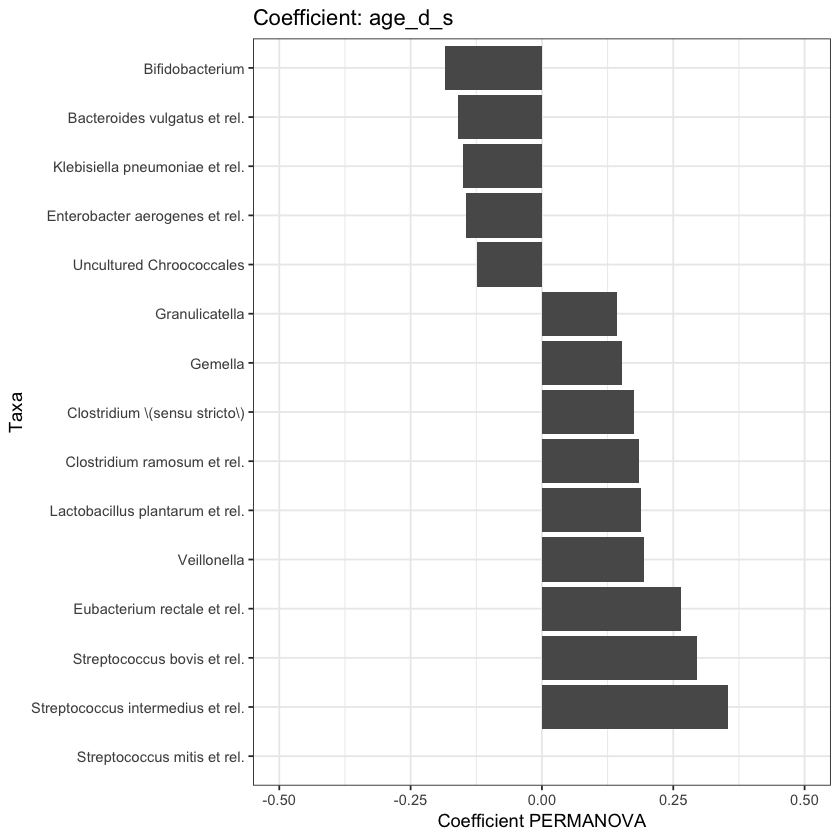

[[1]]

[[2]]

[[3]]

[[4]]


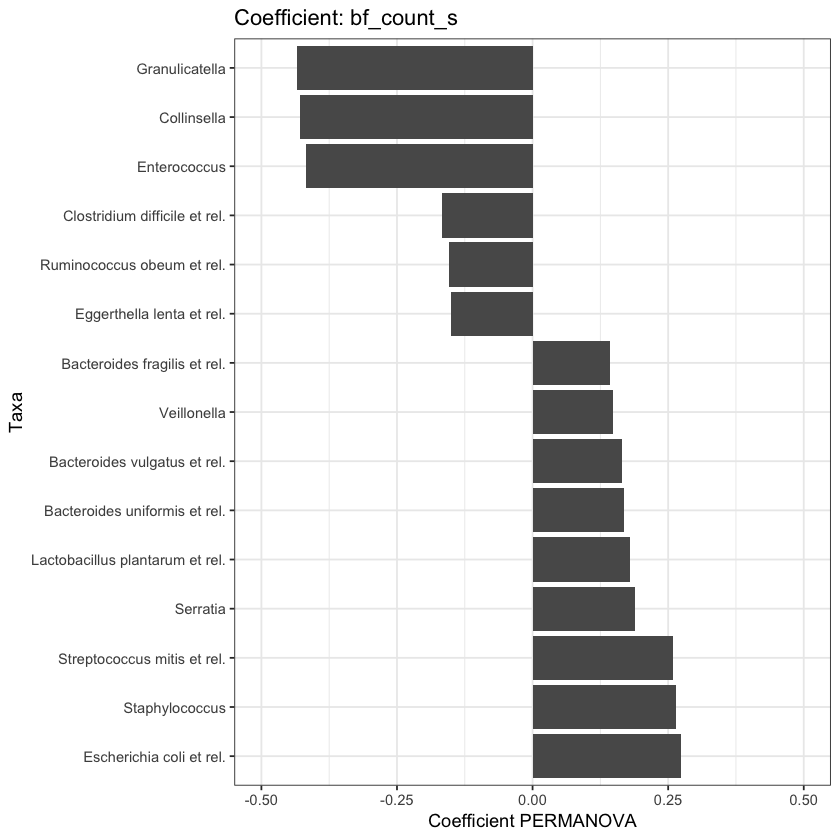

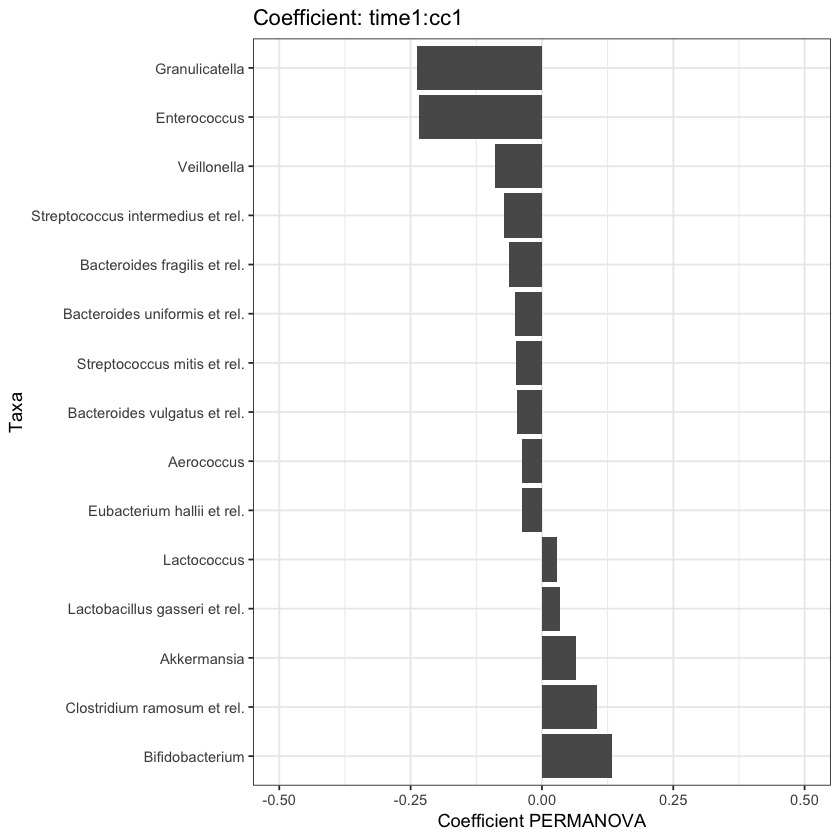

In [496]:
coef_v <- c("time1", "age_d_s", "bf_count_s", "time1:cc1")
pmps <- lapply(coef_v, function(x) {
    coef <- coefficients(pm)[x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.5, 0.5) +
            xlab("Taxa") + ylab("Coefficient PERMANOVA") +
            ggtitle(glue::glue("Coefficient: {x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{x}_clr.png")))
    p
})
pmps

In [497]:
### make tables for permanovs apa
pm_table <- rownames_to_column(pm$aov.tab, "Model Parameters")
pm_table <- 
  mutate_if(pm_table, is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`)) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)
colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )

In [498]:
pm_table

Model Parameter,Sum of Squares,Mean Sum of Squares,F,Df,p,R Square
time,54.240,54.24,1.357,1,0.173,0.007
cc,46.462,46.462,1.162,1,0.303,0.006
age_d_s,65.499,65.499,1.639,1,0.082,0.009
bf_count_s,208.939,208.939,5.228,1,0.001,0.027
time:cc,35.160,35.16,0.88,1,0.55,0.005
Residuals,7194.278,39.968,-,180,-,0.946
Total,7604.580,-,-,185,-,1.000


# Principal Coordinate Analysis

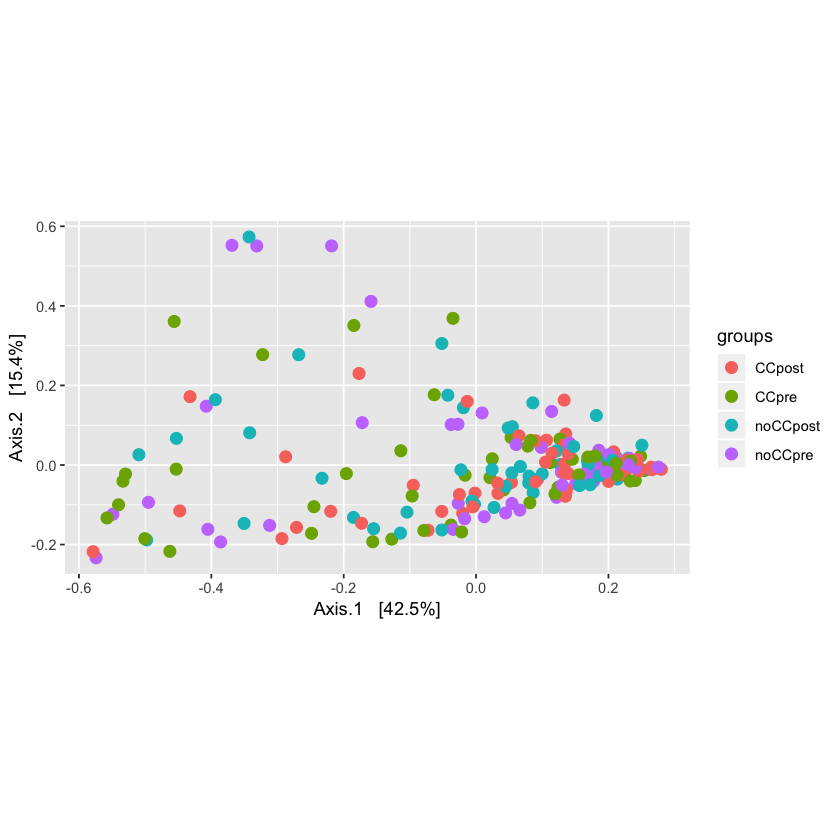

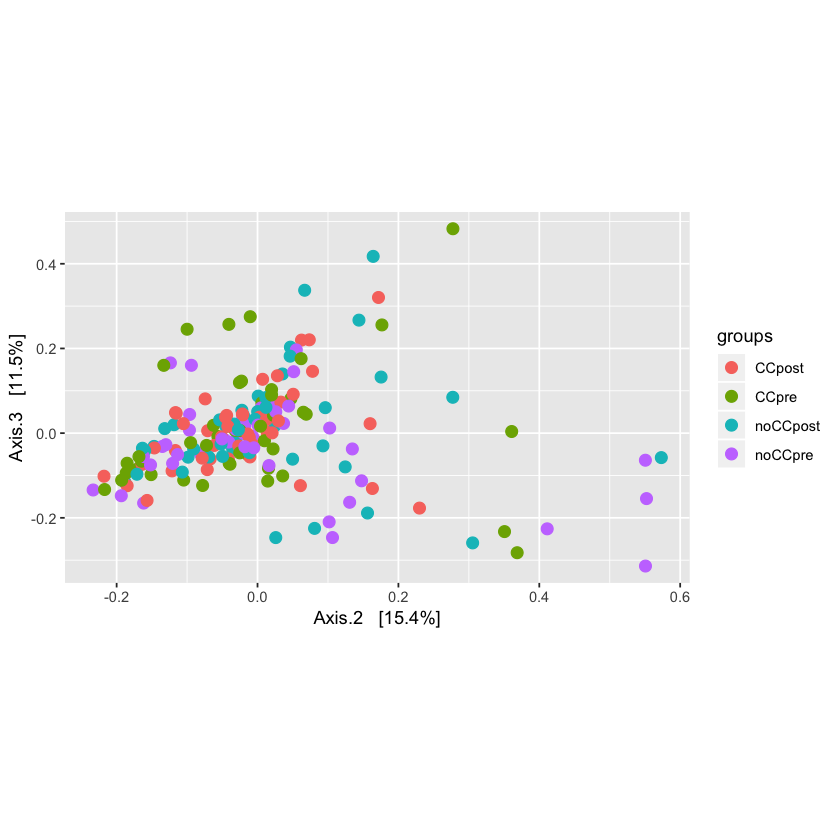

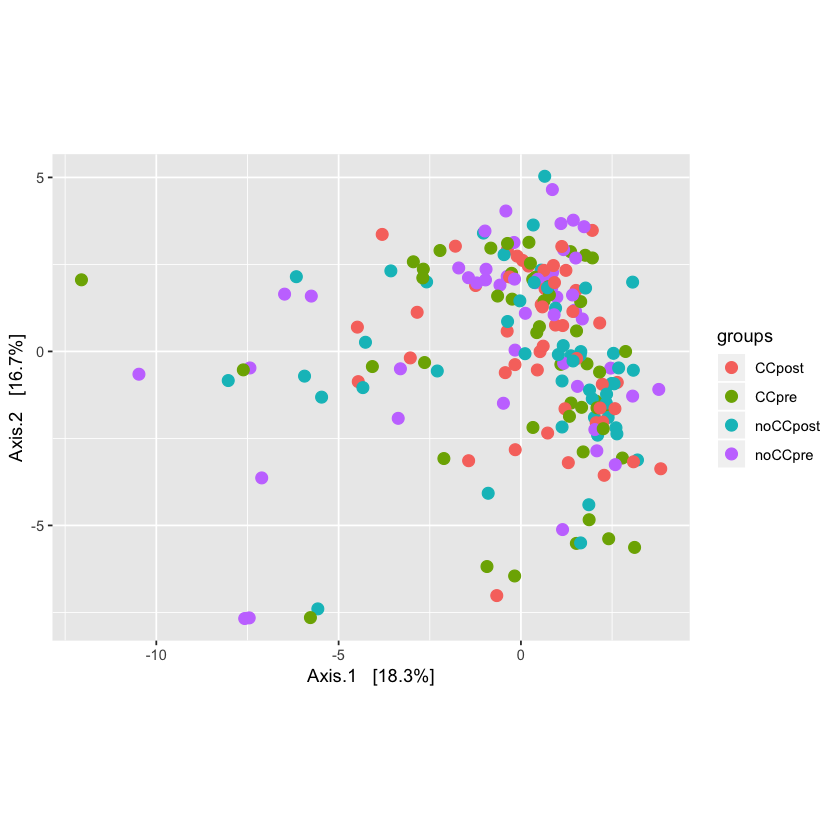

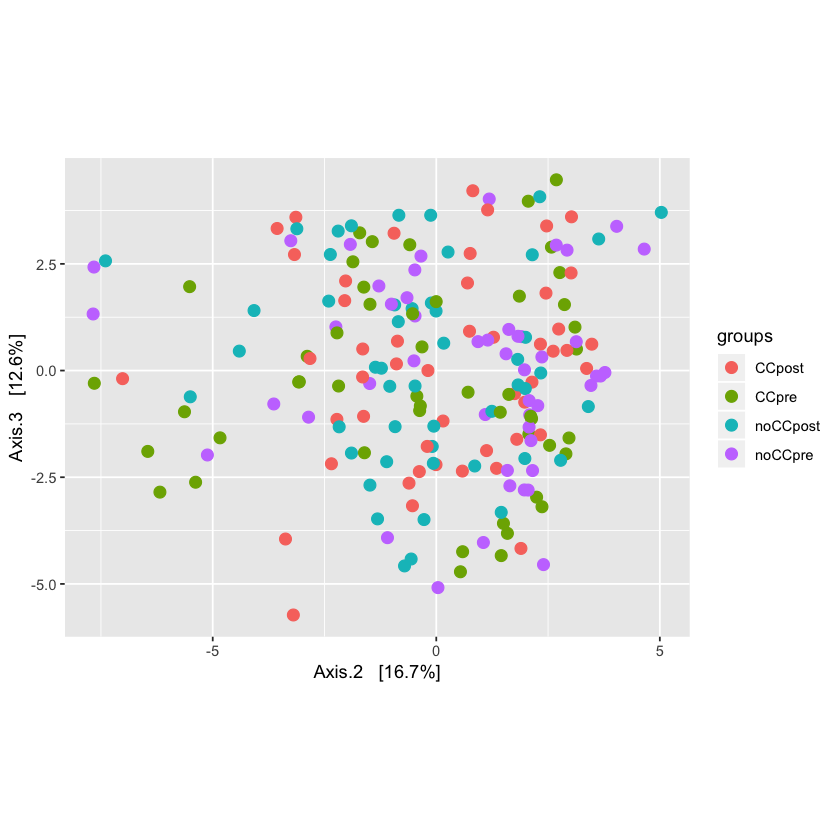

In [501]:
# PCoA bray, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.rel, method = "PCoA", distance = "bray")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.rel, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.rel, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 


# PCoA bray, can we differentiate the post CC from all other infants?
cc_pcoa <- ordinate(pseq.clr, method = "PCoA", distance = "euclidean")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq.clr, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1])) 
# axes 2:3
plot_ordination(pseq.clr, cc_pcoa, color = "groups", axes = 2:3) +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

# Hierarchical Generalized Linear Models

In [432]:
future::availableCores()

system 
     8

In [452]:
library(brms)
library(broom)
library(parallel)
options(mc.cores = 6)

In [453]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

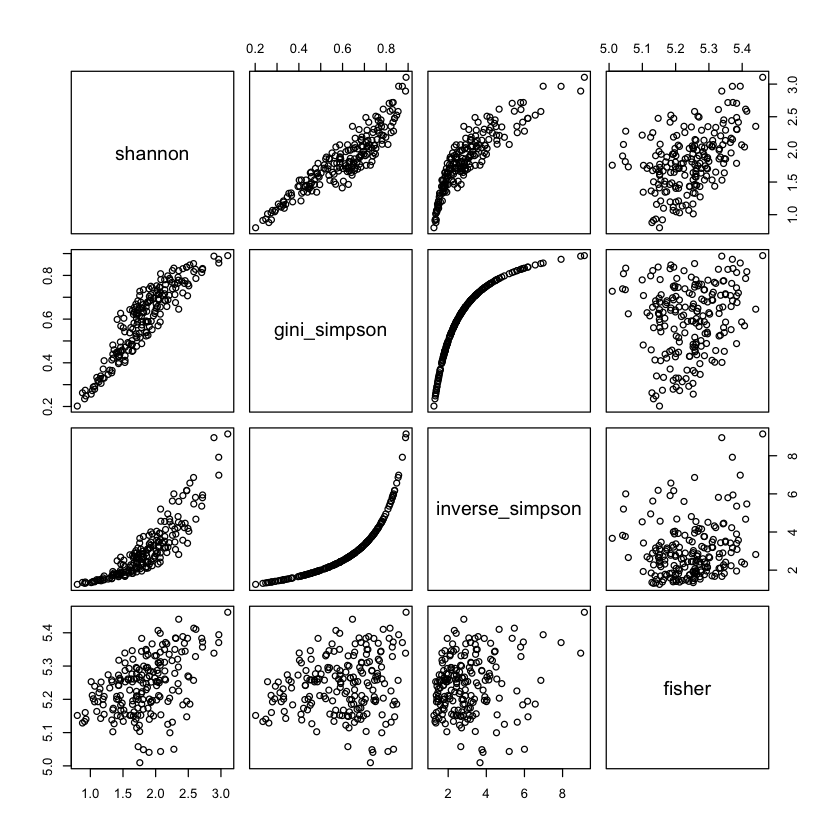

,shannon,gini_simpson,inverse_simpson,fisher
shannon,1.0000000,0.9164821,0.8751891,0.4663419
gini_simpson,0.9164821,1.0000000,0.8733147,0.1690146
inverse_simpson,0.8751891,0.8733147,1.0000000,0.1793231
fisher,0.4663419,0.1690146,0.1793231,1.0000000


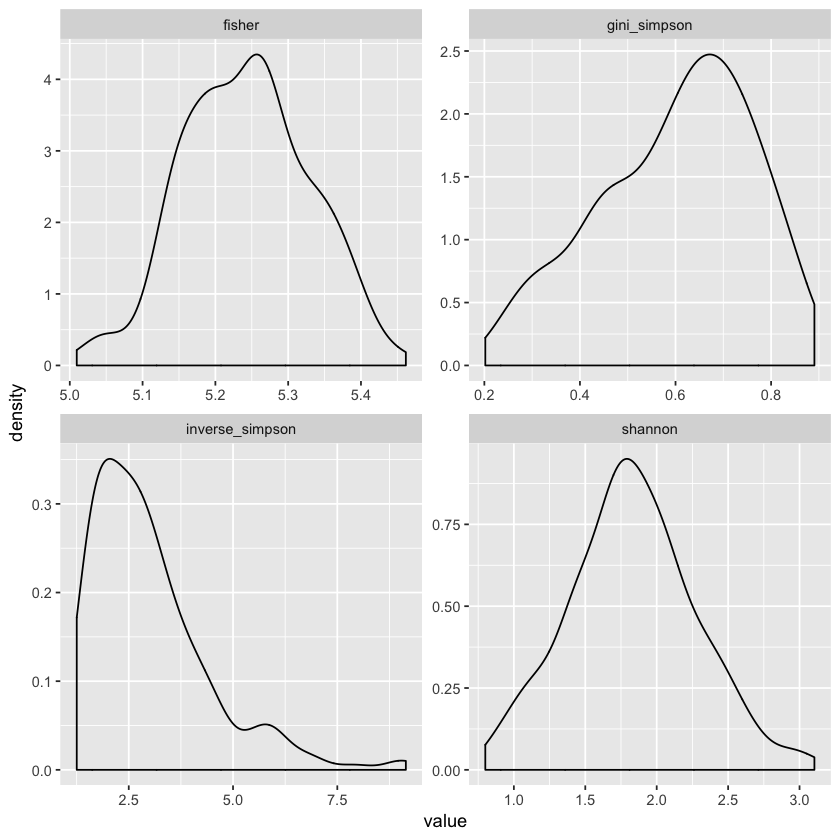

In [435]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [526]:
dir.create(here("models/final_analyses"))
folder <- here("models/final_analyses")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson", "fisher")

Warning message in dir.create(here("models/final_analyses")):
“'/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/final_analyses' already exists”

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [527]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [528]:
prior <- 
    c(
        set_prior("normal(0, 2)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )

brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [529]:
# gaussian family and listwise deletion
div_models <- lapply(diversity_index, brm_div)

In [530]:
# gaussian and mi for bf_count_s missingness
div_models_mi <- lapply(diversity_index, brm_div_mi)

In [ ]:
div_models_mi

In [531]:
# skew family and listwise deletion
div_models_skew <- lapply(diversity_index, brm_div_skew)

In [532]:
# skew family and mi for bf_count_s missingness
div_models_skew_mi <- lapply(diversity_index, brm_div_skew_mi)

In [533]:
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
pp_div <- 
    lapply(1:length(div_models), function(x) {
       pp_plot(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models[[x]], 10,  diversity_index[x])
    } )
pp_div_skew <-
    lapply(1:length(div_models_skew), function(x) {
       pp_plot(div_models_skew[[x]], 10,  diversity_index[x])

    } )
pp_div_skew_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew[[x]], 10,  diversity_index[x])
    } )
pp_div_mi <- 
    lapply(1:length(div_models_mi), function(x) {
       pp_plot(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi <-
    lapply(1:length(div_models_skew_mi), function(x) {
       pp_plot(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )
pp_div_skew_mi_v2 <-
    lapply(1:length(div_models), function(x) {
       pp_plot_v2(div_models_skew_mi[[x]], 10,  diversity_index[x])
    } )

In [541]:
lapply(div_models_mi, function(x) {
    tidy(x)[1:13,]
})

term,estimate,std.error,lower,upper
b_shannon_Intercept,1.89372706,0.08760532,1.753445984,2.037094811
b_bfcounts_Intercept,0.46234939,0.29386602,-0.015742227,0.943000411
b_shannon_ccyes,0.02370585,0.09160557,-0.125224778,0.171806143
b_shannon_timepost,-0.03032074,0.11223950,-0.211971957,0.153263707
b_shannon_age_d_s,0.09488080,0.06176213,-0.006307064,0.196059967
b_shannon_ccyes:timepost,-0.24639353,0.09381100,-0.400108162,-0.093027107
b_bfcounts_ccyes,-0.03407822,0.19982350,-0.362423937,0.290132736
b_bfcounts_timepost,-0.43910298,0.24045711,-0.831404010,-0.042495427
b_bfcounts_shannon,-0.13601546,0.12722321,-0.353022236,0.067359881
b_bfcounts_age_d_s,-0.14331386,0.15061123,-0.392863281,0.097669637


In [542]:
lapply(div_models_skew_mi, function(x) {
    tidy(x)[1:13,]
})
#lapply(div_models_skew_mi, plot)

term,estimate,std.error,lower,upper
b_shannon_Intercept,1.88439961,0.08948574,1.733681580,2.03161369
b_bfcounts_Intercept,0.45135456,0.27270598,0.005144036,0.90418466
b_shannon_ccyes,0.04833789,0.09769097,-0.112292605,0.20676035
b_shannon_timepost,-0.03032499,0.11477478,-0.218164353,0.15692999
b_shannon_age_d_s,0.09938759,0.06182313,-0.002107777,0.20223886
b_shannon_ccyes:timepost,-0.26439782,0.09542340,-0.423324577,-0.10367155
b_bfcounts_ccyes,-0.01936861,0.18564966,-0.323159946,0.28671921
b_bfcounts_timepost,-0.37378396,0.21556695,-0.732124668,-0.01618459
b_bfcounts_shannon,-0.15262150,0.12165606,-0.357031937,0.04574673
b_bfcounts_age_d_s,-0.15062888,0.13667574,-0.376072936,0.07560964


In [559]:
tidy(div_models_skew[[1]]) %>% filter (term == "alpha")

term,estimate,std.error,lower,upper
alpha,-1.971749,2.543389,-6.510013,1.694973


In [571]:
posterior_samples(div_models_skew_mi) %>% colnames()

[1] "b_shannon_Intercept"                                                  
   [2] "b_bfcounts_Intercept"                                                 
   [3] "b_shannon_ccyes"                                                      
   [4] "b_shannon_timepost"                                                   
   [5] "b_shannon_age_d_s"                                                    
   [6] "b_shannon_ccyes.timepost"                                             
   [7] "b_bfcounts_ccyes"                                                     
   [8] "b_bfcounts_timepost"                                                  
   [9] "b_bfcounts_shannon"                                                   
  [10] "b_bfcounts_age_d_s"                                                   
  [11] "b_bfcounts_ccyes.timepost"                                            
  [12] "bsp_shannon_mibf_count_s"                                             
  [13] "sd_subject_id__shannon_Intercept"                                     
  [14] "sd_subject_id__shannon_timepost"                                      
  [15] "sd_subject_id__shannon_age_d_s"                                       
  [16] "sd_subject_id__shannon_mibf_count_s"                                  
  [17] "sd_subject_id__bfcounts_Intercept"                                    
  [18] "sd_subject_id__bfcounts_timepost"                                     
  [19] "sd_subject_id__bfcounts_age_d_s"                                      
  [20] "sd_subject_id__bfcounts_shannon"                                      
  [21] "cor_subject_id__shannon_Intercept__shannon_timepost"                  
  [22] "cor_subject_id__shannon_Intercept__shannon_age_d_s"                   
  [23] "cor_subject_id__shannon_timepost__shannon_age_d_s"                    
  [24] "cor_subject_id__shannon_Intercept__shannon_mibf_count_s"              
  [25] "cor_subject_id__shannon_timepost__shannon_mibf_count_s"               
  [26] "cor_subject_id__shannon_age_d_s__shannon_mibf_count_s"                
  [27] "cor_subject_id__bfcounts_Intercept__bfcounts_timepost"                
  [28] "cor_subject_id__bfcounts_Intercept__bfcounts_age_d_s"                 
  [29] "cor_subject_id__bfcounts_timepost__bfcounts_age_d_s"                  
  [30] "cor_subject_id__bfcounts_Intercept__bfcounts_shannon"                 
  [31] "cor_subject_id__bfcounts_timepost__bfcounts_shannon"                  
  [32] "cor_subject_id__bfcounts_age_d_s__bfcounts_shannon"                   
  [33] "sigma_shannon"                                                        
  [34] "sigma_bfcounts"                                                       
  [35] "alpha_shannon"                                                        
  [36] "alpha_bfcounts"                                                       
  [37] "r_subject_id__shannon.202.Intercept."                                 
  [38] "r_subject_id__shannon.204.Intercept."                                 
  [39] "r_subject_id__shannon.207.Intercept."                                 
  [40] "r_subject_id__shannon.210.Intercept."                                 
  [41] "r_subject_id__shannon.211.Intercept."                                 
  [42] "r_subject_id__shannon.213.Intercept."                                 
  [43] "r_subject_id__shannon.216.Intercept."                                 
  [44] "r_subject_id__shannon.228.Intercept."                                 
  [45] "r_subject_id__shannon.233.Intercept."                                 
  [46] "r_subject_id__shannon.234.Intercept."                                 
  [47] "r_subject_id__shannon.237.Intercept."                                 
  [48] "r_subject_id__shannon.240.Intercept."                                 
  [49] "r_subject_id__shannon.241.Intercept."                                 
  [50] "r_subject_id__shannon.245.Intercept."                                 
  [51] "r_subject_id__shannon.249.Intercept."        

In [590]:
calc_treatment_effect <- function(model, var_name, summarise = TRUE, stat = "mean") {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- posterior_samples(model) %>%
        select(
            glue("b_{var_name}_Intercept"), 
            glue("b_{var_name}_ccyes"), 
            glue("b_{var_name}_timepost"), 
            glue("b_{var_name}_ccyes:timepost")) %>%
        rename(
            no_pre = glue("b_{var_name}_Intercept"), 
            yes_pre = glue("b_{var_name}_ccyes"),
            no_post = glue("b_{var_name}_timepost"),
            yes_post = glue("b_{var_name}_ccyes:timepost")) %>%
        mutate(
            yes_post = no_pre + yes_pre + no_post + yes_post,
            no_post = no_pre + no_post,
            yes_pre = no_pre + yes_pre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

plot_effects <- function(model, var_name) {
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df_sum <- calc_treatment_effect(model, var_name)
    df <- calc_treatment_effect(model, var_name, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            ggtitle(var_name) +
            theme_bw()
}


In [594]:
lapply(1:length(diversity_index), function(x) {
    var_name <- diversity_index[x]
    var_name <- gsub("_", "", var_name)
    var_name <- gsub("\\.", "", var_name)
    df <- calc_treatment_effect(div_models_mi[[x]], var_name, summarise = F)
    df <- df %>% 
        mutate(            
            yespost_yespre = yes_post - yes_pre,
            yespost_nopre = yes_post - no_pre,
            yespost_nopost = yes_post - no_post) %>%
        select(yespost_yespre, yespost_nopre, yespost_nopost) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
})


comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.2226877,-0.4055381,-0.04235441,0.99025
yespost_nopre,-0.2530084,-0.5605460,0.03995186,0.95050
yespost_yespre,-0.2767143,-0.4993106,-0.04436296,0.99050
comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.6238298,-1.208662,-0.02072643,0.97900
yespost_nopre,-0.8280030,-1.699692,0.07057180,0.96650
yespost_yespre,-0.9626860,-1.712767,-0.21015779,0.99425
comparison,mean_diff,lower,upper,prob
yespost_nopost,-0.08354286,-0.1506620,-0.01542162,0.99125
yespost_nopre,-0.10914779,-0.2131054,0.01629612,0.97025


Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image
Warning message:
“Ignoring unknown aesthetics: y”Saving 7 x 7 in image


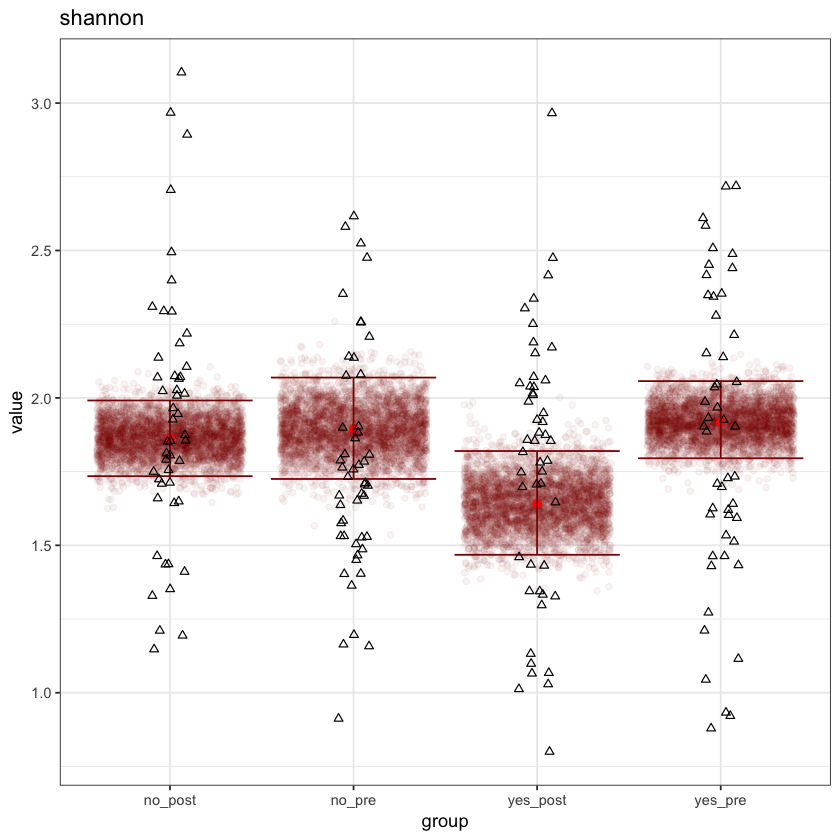

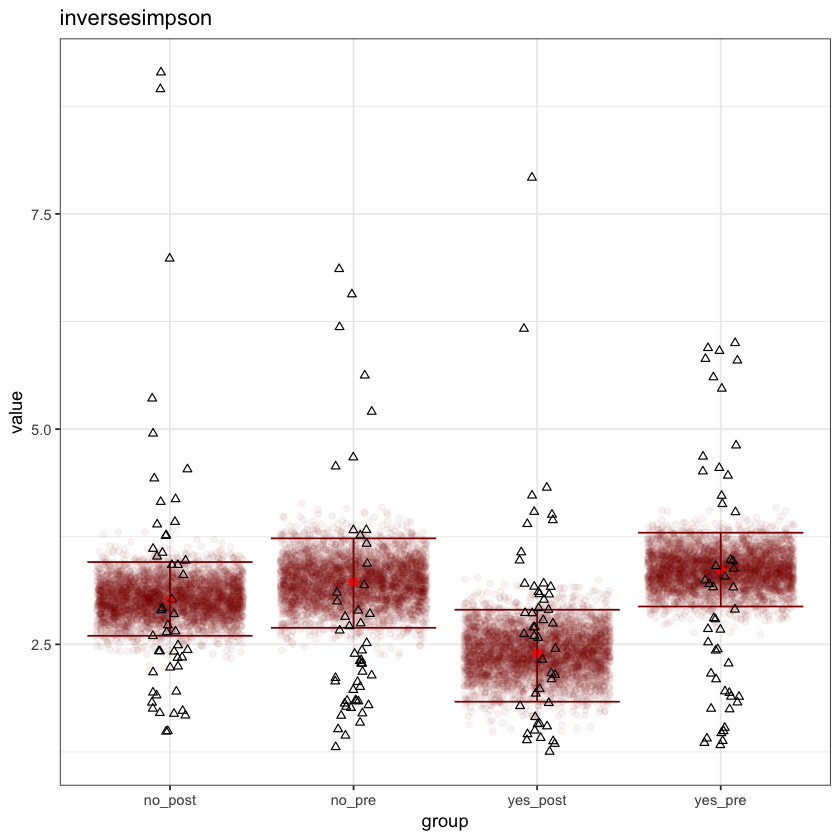

[[1]]

[[2]]

[[3]]

[[4]]


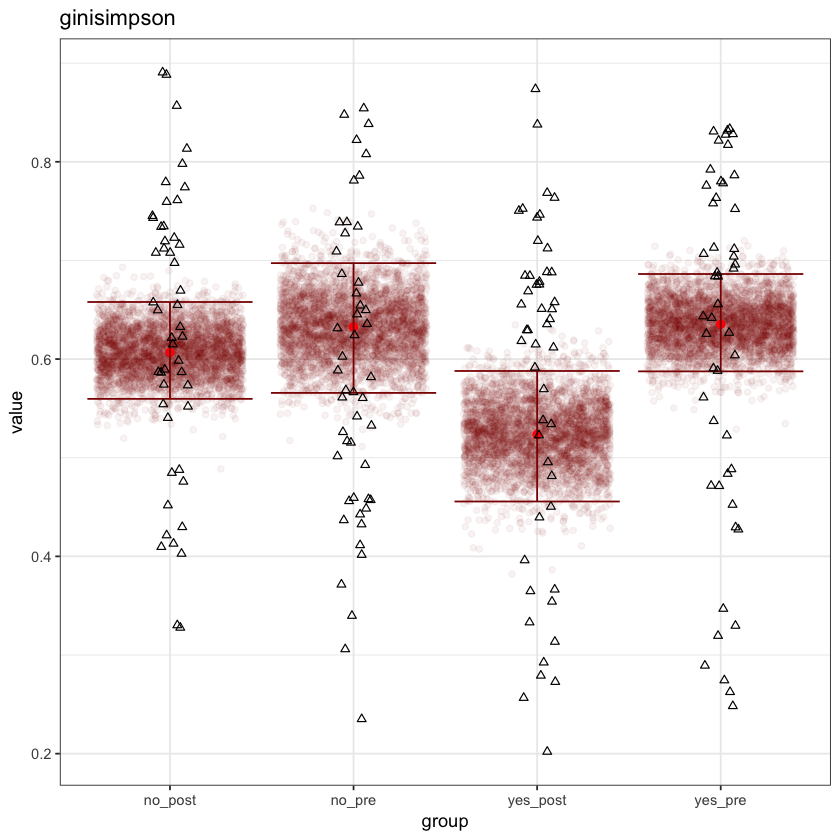

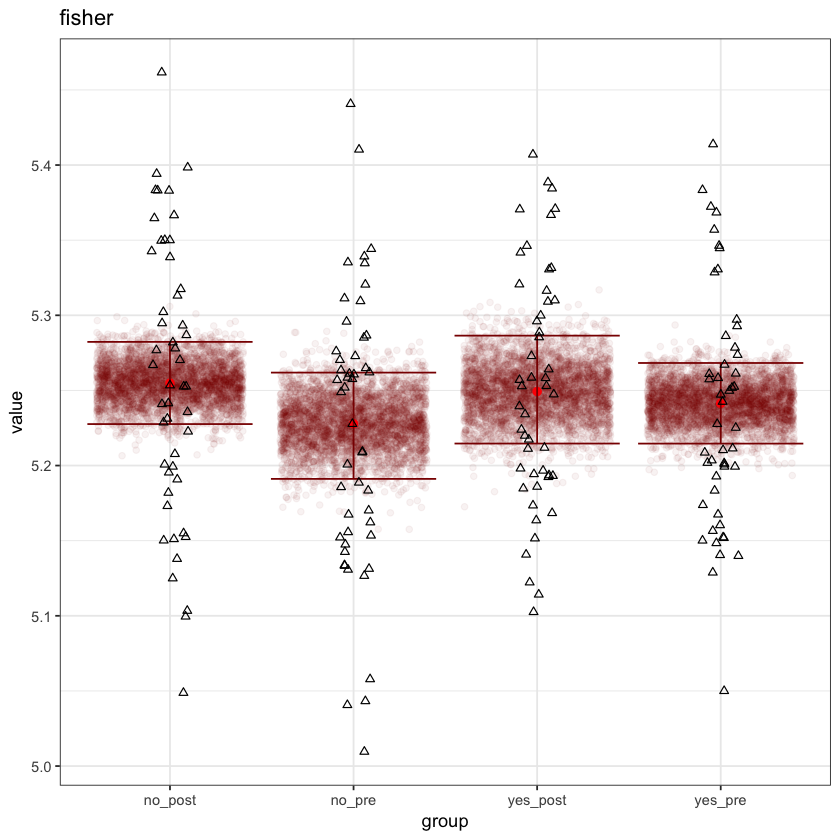

In [604]:
meta <- meta %>% mutate(
    group = ifelse(groups == "noCCpost", "no_post", ifelse(groups == "CCpost", "yes_post", ifelse(groups == "CCpre", "yes_pre", "no_pre")))
)
lapply(1:length(diversity_index), function(x) {
    p <- plot_effects(div_models_mi[[x]], diversity_index[x]) +
            geom_jitter(data = meta, aes_string("group", diversity_index[x]), width = 0.1, shape = 2)
    ggsave(here(glue("fig/parameter_plot_{x}.png")))
    p
    })


# Differential abundance testing

In [454]:
# specify prior 
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/final_analyses/differential_abundance/")

# define fitting function for fixed sigma
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
        
        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [455]:
models_sn <- mclapply(genus, brm_sn_mi)